In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics

In [45]:
# Read in the data & setup
Data = pd.read_csv("houses.csv")
onee = OneHotEncoder(drop='first')
imp = SimpleImputer()

In [46]:
# Fill in missing data for total bedrooms
imp = SimpleImputer()
Data['total_bedrooms'] = imp.fit_transform(Data[['total_bedrooms']])

Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [47]:
# Create features X and targets y
y = Data['median_house_value']
X = Data.drop(columns=['median_house_value'])

# Split dataset into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [48]:
# Create transformation
transformation = ColumnTransformer(transformers=[('one-hot', onee, ["ocean_proximity"])], remainder='passthrough')
transformation.fit(X_train)
transformation.get_feature_names_out()
data_transformed = pd.DataFrame(transformation.transform(X_train), columns=transformation.get_feature_names_out())

In [49]:
# Train our model
X_train_transformed = transformation.fit_transform(X_train)
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train_transformed, y_train)

X_test_transformed = transformation.transform(X_test)
y_pred = neigh.predict(X_test_transformed)


0.22600051279899724

In [51]:
sklearn.metrics.explained_variance_score(y_test, y_pred)

0.22600051279899724

<Axes: >

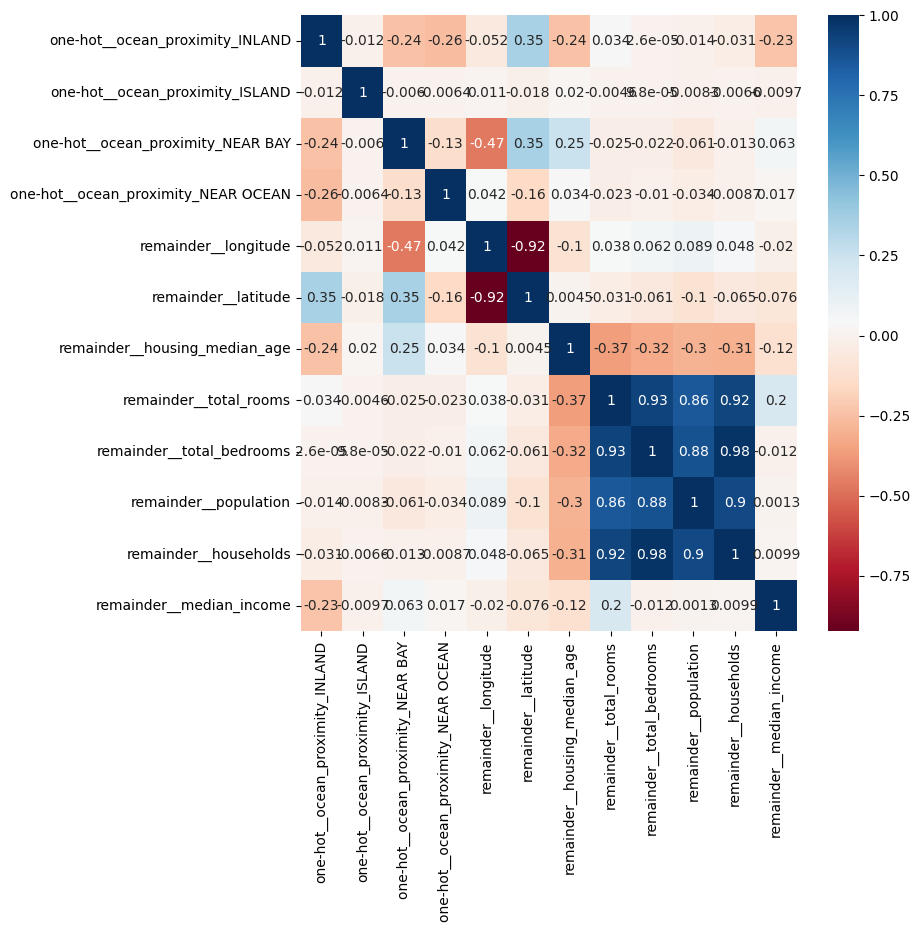

In [50]:
# Plot heat map
plt.figure(figsize=(8,8))
sns.heatmap(data_transformed.corr(), cmap="RdBu", annot=True)